# Evaluation Report: Fine-Tuned LLaMA 2 Model with Justification

In [1]:
!pip install -q transformers datasets peft accelerate bitsandbytes #install librarys we need to work with Hugging Face models and fine-tuning tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes #install library which enables quantized model loading (8-bit or 4-bit)

In [ ]:
from huggingface_hub import login
login("") #paste your own login here

In [79]:
import json
from datasets import Dataset # Hugging Face's datasets library

# Load JSONL manually
with open("data.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

dataset = Dataset.from_list(data) # Convert the list of dictionaries into a Hugging Face Dataset object
print(dataset[0])


{'instruction': 'Q1 statement', 'input': 'We searched MEDLINE and EMBASE for articles about tuberculosis resistance in Saudi Arabia. We used the terms: Saudi Arabia, tuberculosis, Mycobacterium tuberculosis, drug resistance, drug susceptibility, and resistance. In addition, the references of the retrieved articles were manually searched to identify additional studies. Â\xa0 Data extraction The prevalence of drug resistance (number and percentage) and the number of tested isolates were extracted into an excel data collection sheet (Microsoft Excel 2010). Â\xa0 Statistical Analysis The meta-analyses and Forest Plots were done using a Microsoft Excel spreadsheet as described by Neyeloff et al.9 The random effects model was used and assumed that the prevalence of the studies followed a normal distribution.10 For cells with zero resistance rate, 0.5 was added to all cells of study results tables where zero was observed similar to the Mantel-Haenszel methods.11 The heterogeneity of the inclu

This cell loads the tokenizer and quantized LLaMA 2 model (7B parameter version) using Hugging Face Transformers.The tokenizer is fetched using AutoTokenizer,the model is loaded in 4-bit mode with device_map="auto" for automatic placement.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "meta-llama/Llama-2-7b-hf" # Define the model name to be used (LLaMA 2 - 7B version)

quant_config = BitsAndBytesConfig(
    load_in_8bit=True, # Load the model in 8-bit precision to reduce memory usage
    llm_int8_threshold=6.0 # Threshold for using int8 layers (used during mixed-precision loading)
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
# Load the language model (causal LM version), here loaded in 4-bit precision for even lower memory footprint
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",  # or your base model
    load_in_4bit=True,
    device_map="auto" # Automatically map model layers to available GPU(s)
)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

This cell applies LoRA (Low-Rank Adaptation) to the LLaMA model for parameter-efficient fine-tuning. LoRA works by injecting trainable low-rank matrices into specific parts of the model—in this case, the q_proj and v_proj attention projection layers. This allows the model to be fine-tuned with significantly fewer trainable parameters, making training faster and less memory-intensive(this is very important in this case, because we use Colab which has limitation). The configuration uses a rank of 16, a scaling factor (lora_alpha) of 32, and applies a small dropout for regularization.

In [ ]:
from peft import LoraConfig, get_peft_model
import torch
# Define LoRA (Low-Rank Adaptation) configuration
lora_config = LoraConfig(
    r=16, # Rank of the low-rank update matrices
    lora_alpha=32, # Scaling factor for the updates
    target_modules=["q_proj", "v_proj"], # Apply LoRA to these attention projection modules
    lora_dropout=0.05,  # Dropout applied to LoRA layers during training
    bias="none",  # Don't adapt the bias parameters
    task_type="CAUSAL_LM"  # Specify task type (Causal Language Modeling)
)
model = get_peft_model(model, lora_config) # Apply the LoRA configuration to the base model

NameError: name 'model' is not defined

This cell reformats each data example in the dataset into a structured prompt format compatible with instruction-tuned language models like LLaMA 2.This formatting aligns with the input style expected by instruction-following models, making the data suitable for fine-tuning or inference. The transformation is applied to the entire dataset using .map().

In [ ]:
def format_instruction(example):
    return {
        "text": f"""### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:\n{example['output']}"""
    }
# Apply formatting function to each example in the dataset
dataset = dataset.map(format_instruction)

Map:   0%|          | 0/1194 [00:00<?, ? examples/s]

This cell tokenizes the reformatted text prompts for training with a causal language model.
* The tokenizer is loaded using the same model name to ensure compatibility with the model architecture.

* Padding is explicitly defined to avoid errors (some models don't have a default pad token, so the end-of-sequence token is reused).

* The tokenize function encodes the text field into token IDs, applies truncation/padding, and creates a "labels" field by copying "input_ids" (this is standard in causal language modeling where the model predicts the next token).

* The .map() function applies tokenization across the dataset, and the original "text" field is removed to avoid redundancy.




In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True) # Load tokenizer for the specified model (e.g., LLaMA 2)

tokenizer.pad_token = tokenizer.eos_token # Ensure tokenizer has a padding token (use EOS token if missing)
# Define function to tokenize each example
def tokenize(example):
    result = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    result["labels"] = result["input_ids"].copy() # use input tokens as training labels
    return result

# Apply tokenization to the dataset and remove original 'text' column
tokenized_dataset = dataset.map(tokenize, remove_columns=["text"])

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:902: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Map:   0%|          | 0/1194 [00:00<?, ? examples/s]

This cell sets up and starts the fine-tuning process using Hugging Face's Trainer API:

* TrainingArguments defines how the model should be trained, including batch size, learning rate, logging frequency, and checkpoint strategy.

* DataCollatorForLanguageModeling prepares the inputs for causal language modeling (next-token prediction), using our tokenizer. Masked Language Modeling (MLM) is disabled since LLaMA is a causal model.

* Trainer manages the entire training loop, including batching, loss calculation, backpropagation, and checkpointing.

* The train() method kicks off training on the prepared dataset with LoRA applied for parameter-efficient fine-tuning.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Set training hyperparameters and configurations
training_args = TrainingArguments(
    output_dir="./llama-finetuned", # Where to save model checkpoints
    per_device_train_batch_size=1, # Small batch size for limited VRAM
    gradient_accumulation_steps=16,
    num_train_epochs=3, # Train for 3 epochs
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=1,
    logging_steps=10,  # Log training stats every 10 steps
    save_strategy="epoch",  # Save model checkpoint after each epoch
    report_to=None,  # Disable reporting to external tools (like wandb)
)

# Create a data collator for causal language modeling (no masked tokens)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Initialize Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start fine-tuning
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-10-08ba5a275e86>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Step,Training Loss
10,1.986300
20,1.776200
30,1.656100
40,1.583400
50,1.594300
60,1.573200
70,1.543300
80,1.511300
90,1.504200
100,1.466800


Step,Training Loss
10,1.986300
20,1.776200
30,1.656100
40,1.583400
50,1.594300
60,1.573200
70,1.543300
80,1.511300
90,1.504200
100,1.466800


TrainOutput(global_step=225, training_loss=1.5072265858120388, metrics={'train_runtime': 5008.3291, 'train_samples_per_second': 0.715, 'train_steps_per_second': 0.045, 'total_flos': 7.27988822826025e+16, 'train_loss': 1.5072265858120388, 'epoch': 3.0})

Downloading fine-tuned model to use it in the future

In [ ]:
model.save_pretrained("./llama-finetuned")
tokenizer.save_pretrained("./llama-finetuned")
!zip -r model.zip ./llama-finetuned
from google.colab import files
files.download('model.zip')

  adding: llama-finetuned/ (stored 0%)
  adding: llama-finetuned/special_tokens_map.json (deflated 73%)
  adding: llama-finetuned/checkpoint-225/ (stored 0%)
  adding: llama-finetuned/checkpoint-225/special_tokens_map.json (deflated 73%)
  adding: llama-finetuned/checkpoint-225/optimizer.pt (deflated 8%)
  adding: llama-finetuned/checkpoint-225/adapter_model.safetensors (deflated 8%)
  adding: llama-finetuned/checkpoint-225/tokenizer.model (deflated 55%)
  adding: llama-finetuned/checkpoint-225/rng_state.pth (deflated 25%)
  adding: llama-finetuned/checkpoint-225/tokenizer_config.json (deflated 68%)
  adding: llama-finetuned/checkpoint-225/scaler.pt (deflated 60%)
  adding: llama-finetuned/checkpoint-225/scheduler.pt (deflated 56%)
  adding: llama-finetuned/checkpoint-225/training_args.bin (deflated 52%)
  adding: llama-finetuned/checkpoint-225/trainer_state.json (deflated 75%)
  adding: llama-finetuned/checkpoint-225/adapter_config.json (deflated 54%)
  adding: llama-finetuned/checkpo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Example how model answer to one question. You can choose any other question

In [8]:
label_statements = {
    "Q1": "This systematic review claimed to comply with the PRISMA or other guidelines.",
    "Q2": "A review protocol exists and its registration information was available.",
    "Q3": "Inclusion criteria for primary studies were clearly defined.",
    "Q4": "No language-based exclusion criteria were defined.",
    "Q5": "Information sources (e.g., bibliographic databases) in the search were described.",
    "Q6": "Multiple electronic bibliographic databases were searched.",
    "Q7": "Electronic database searching was complemented with other information sources to identify relevant reports.",
    "Q8": "The identification of unpublished reports was explicitly made possible by the search.",
    "Q9": "The date last searched for information was described.",
    "Q10": "Full electronic search strategy was provided for at least one database.",
    "Q11": "Efforts were made to minimise error in selection of studies by having more than one author independently participated in the study selection process.",
    "Q12": "Efforts were made to minimise error in data collection by having more than one author independently participating in the data extraction from reports.",
    "Q13": "A prespecified form was used for data extraction from reports.",
    "Q14": "Processes for obtaining and confirming data from investigators were described.",
    "Q15": "Efforts to avoid double counting of participants/studies were described.",
    "Q16": "Variables for which data were sought were listed.",
    "Q17": "The risk of bias (or methodological quality) of individual studies was formally assessed using appropriate criteria.",
    "Q18": "Efforts were made to minimise error in risk of bias assessment, namely by having it independently conducted by at least two reviewers.",
    "Q19": "For procedures involving more than one reviewer, methods for solving disagreements were provided.",
    "Q20": "Methods used to assess certainty (or confidence) in the body of evidence for an outcome (e.g., by application of the GRADE framework) were described.",
    "MA": "Was meta-analysis performed?",
    "A": "Meta-analytical summary measures were stated.",
    "B": "Meta-analytical model and methods were described.",
    "C": "Methods for assessing between-study variation (heterogeneity) and/or inconsistency were described.",
    "D": "Assessment of the risk of bias that may affect the cumulative evidence (publication bias or selective reporting) has been performed.",
    "E": "An intention to perform additional analyses has been reported (e.g., sensitivity or subgroup analyses, meta-regression) even if that not had been done on account of low heterogeneity or insufficient number of primary studies.",
    "F": "Biases in primary studies were addressed in meta-analysis."
}


In [34]:
# Sample input
sample = data[56]  # or pick any index

# Extract instruction like "Q1 statement"
instruction = sample["instruction"]
input_text = sample["input"]
true_output = sample["output"]

# Extract the label (e.g., "Q1") from "Q1 statement"
label = instruction.split()[0]
# Build new instruction
full_instruction = f"Instruction: {label}. {label_statements[label]}"

# Debug
print("INSTRUCTION:\n", full_instruction)
print("\nINPUT:\n", input_text)
print("\nTRUE OUTPUT:\n", true_output)

# Call model
output = generate(input_text, full_instruction)

# Post-process output
cleaned = output.split("Answer:", 1)[-1].strip()

# Final result
print("MODEL OUTPUT:\n")
print("Answer:", cleaned)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


INSTRUCTION:
 Instruction: Q3. Inclusion criteria for primary studies were clearly defined.

INPUT:
 2.1 Search strategy and selection criteria We focused only on studies which externally validated existing asthma predictive tools, alongside the studies in which they were originally developed.  Our methods were based on the  CHecklist for critical Appraisal and data extraction for systematic Reviews of prediction Modelling Studies (CHARMS)32 and the  Preferred Reporting Items for Systematic reviews and Metaâ€Analyses (PRISMA) statements. 33  The protocol was registered on PROSPERO (CRD42016035727). An electronic search was performed on 11 July 2017 by a search of two databases, MEDLINE and EMBASE, using both free text and MESH terms. The search strategies are supplied as Supporting Information (Figures S1 and S2). In addition, further studies were traced through crossâ€checking of reference lists from identified relevant papers. Studies of all designs were included only when they: (a

In [18]:
import json

with open("data.jsonl") as f:
    test_data = [json.loads(line) for line in f]

This function generates a binary answer and a justification using the fine-tuned LLaMA model:


In [81]:
def generate(input_text, instruction):
      # Create a prompt that guides the model to output a binary answer (0 or 1) with a justification.
    prompt = (
        "You are a helpful assistant. Your task is to analyze the following input and decide whether the answer is 0 (No) or 1 (Yes), "
        "based on the instruction provided.\n"
        "Do not explain anything before the answer. Always start with 'Answer:' followed by 0 or 1, and then 'Justification:'.\n\n"
        f"Instruction:\n{instruction}\n\n"
        f"Input:\n{input_text}\n\n"
        f"Output:\nAnswer:"
    )

      # Tokenize the prompt and move it to the GPU
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
      # Generate output from the model with max 100 new tokens
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id
    )
      # Decode and return the generated output (skip special tokens like <pad>)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [16]:
from tqdm import tqdm

This cell performs evaluation of the fine-tuned model on a test dataset:


In [20]:
results = {"instruction": [], "input": [], "true_output": [], "model_output": []}

# Loop through the first 100 test samples
for sample in tqdm(test_data[:100]):
    raw_instruction = sample["instruction"]
    label = raw_instruction.split()[0]
    full_instruction = f"Instruction: {label}. {label_statements[label]}"

    input_text = sample["input"]
    true_output = sample["output"]

    # Generate model prediction
    raw_output = generate(input_text, full_instruction)

    # Clean the model output to extract text after 'Answer:, because model repeat the question and generate too much useless text
    cleaned_output = raw_output.split("Answer:", 1)[-1].strip()

    # Store results
    results["instruction"].append(full_instruction)
    results["input"].append(input_text)
    results["true_output"].append(true_output)
    results["model_output"].append(cleaned_output)

100%|██████████| 100/100 [15:30<00:00,  9.30s/it]


In [50]:
import pandas as pd

df = pd.DataFrame(results)
df[["instruction", "input", "true_output", "model_output"]].head(10)

,instruction,input,true_output,model_output
0,Instruction: Q1. This systematic review claime...,We searched MEDLINE and EMBASE for articles ab...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
1,Instruction: Q2. A review protocol exists and ...,We searched MEDLINE and EMBASE for articles ab...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
2,Instruction: Q3. Inclusion criteria for primar...,We searched MEDLINE and EMBASE for articles ab...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
3,Instruction: Q1. This systematic review claime...,Materials and Methods Data Sources A computer-...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
4,Instruction: Q2. A review protocol exists and ...,Materials and Methods Data Sources A computer-...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
5,Instruction: Q3. Inclusion criteria for primar...,Materials and Methods Data Sources A computer-...,1. Justification: Studies in which researchers...,"' followed by 0 or 1, and then 'Justification:..."
6,Instruction: Q1. This systematic review claime...,Methods Search strategy Two independent review...,1. Justification: MethodsSearch strategyTwo in...,"' followed by 0 or 1, and then 'Justification:..."
7,Instruction: Q2. A review protocol exists and ...,Methods Search strategy Two independent review...,0. Justification: There is no information on t...,"' followed by 0 or 1, and then 'Justification:..."
8,Instruction: Q3. Inclusion criteria for primar...,Methods Search strategy Two independent review...,1. Justification: To be eligible for inclusion...,"' followed by 0 or 1, and then 'Justification:..."
9,Instruction: Q1. This systematic review claime...,Methods A systematic review of the published l...,1. Justification: A systematic review of the p...,"' followed by 0 or 1, and then 'Justification:..."


This cell defines helper functions to extract the predicted answer and justification from both the true label and model outputs.

In [68]:
import re

def extract_answer(text):
    # Find the first digit (0 or 1) after "Answer:"
    match = re.search(r"Answer:\s*([01])", text)
    if match:
        return match.group(1)
    return None  # or raise an error, or return a default value

def extract_justification_true(text):
    # Extract everything after "Justification:"
    parts = text.split("Justification:", 1)
    if len(parts) == 2:
        return parts[1].strip()
    return ""

def extract_justification_model(text: str) -> str:
    parts = text.split("Justification:")
    if len(parts) >= 3:
        # Take text after second occurrence of 'Justification:'
        justification = parts[2].strip()
        return justification
    elif len(parts) == 2:
        # fallback: only one 'Justification:' found, take what's after it
        return parts[1].strip()
    else:
        # no 'Justification:' found
        return ""

This code evaluates the model’s predictions against the true answers and justifications. It compares the classification answers exactly (0 or 1), and for justifications, it performs a semantic similarity comparison using sentence embeddings. If the semantic similarity between the model’s justification and the true justification exceeds a defined threshold, it counts as correct; otherwise, incorrect. The code tracks the number of correct and incorrect classifications and justifications.

In [76]:
from sentence_transformers import SentenceTransformer, util

embedder = SentenceTransformer("all-MiniLM-L6-v2")
SIM_THRESHOLD = 0.5  # similarity threshold for considering justifications "correct"

classification_score = {"correct": 0, "incorrect": 0}
justification_score = {"correct": 0, "incorrect": 0}

for true_out, model_out in zip(results["true_output"], results["model_output"]):
    try:
        true_answer = true_out.split(".")[0].strip()
        model_answer = extract_answer(model_out)

        true_just = extract_justification_true(true_out)
        model_just = extract_justification_model(model_out)

        # Basic normalization for answers
        true_answer_norm = true_answer.lower() if true_answer is not None else None
        model_answer_norm = model_answer.lower() if model_answer is not None else None

        # Compare answers exactly as before
        if true_answer_norm == model_answer_norm and true_answer_norm is not None:
            classification_score["correct"] += 1
        else:
            classification_score["incorrect"] += 1

        # Semantic similarity for justifications
        if true_just and model_just:
            emb_true_just = embedder.encode(true_just, convert_to_tensor=True)
            emb_model_just = embedder.encode(model_just, convert_to_tensor=True)
            similarity = util.cos_sim(emb_true_just, emb_model_just).item()

            if similarity >= SIM_THRESHOLD:
                justification_score["correct"] += 1
            else:
                justification_score["incorrect"] += 1
        else:
            # If either justification is missing, count as incorrect
            justification_score["incorrect"] += 1

    except Exception as e:
        # You can print the error for debugging if needed
        # print(f"Error: {e}")
        continue

In [77]:
print(classification_score)
print(justification_score)

{'correct': 57, 'incorrect': 43}
{'correct': 21, 'incorrect': 79}


This code plotting th result.

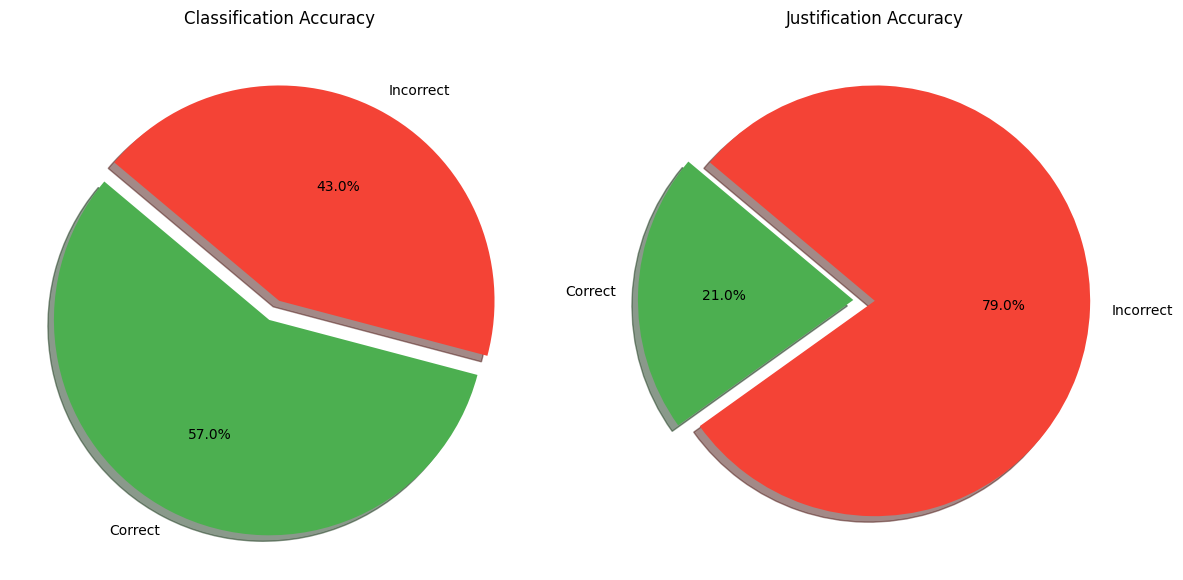

In [78]:
import matplotlib.pyplot as plt

# Plot classification accuracy pie chart
labels = 'Correct', 'Incorrect'
sizes = [classification_score["correct"], classification_score["incorrect"]]
colors = ['#4CAF50', '#F44336']
explode = (0.1, 0)  # Slightly separate the correct slice

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Classification Accuracy')

# Plot justification accuracy pie chart
sizes = [justification_score["correct"], justification_score["incorrect"]]

plt.subplot(1, 2, 2)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Justification Accuracy')

plt.tight_layout()
plt.show()

Uploading saved model to use it again.

before running this cells please run cells № 1, 2, 3, 5

In [5]:
from google.colab import files
uploaded = files.upload()  # this opens a file upload dialog

Saving model.zip to model.zip


In [6]:
!unzip -o model.zip -d llama-finetuned

Archive:  model.zip
   creating: llama-finetuned/llama-finetuned/
  inflating: llama-finetuned/llama-finetuned/special_tokens_map.json  
   creating: llama-finetuned/llama-finetuned/checkpoint-225/
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/special_tokens_map.json  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/optimizer.pt  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/adapter_model.safetensors  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/tokenizer.model  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/rng_state.pth  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/tokenizer_config.json  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/scaler.pt  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/scheduler.pt  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/training_args.bin  
  inflating: llama-finetuned/llama-finetuned/checkpoint-225/trainer_state.json  
  infla

In [7]:
from peft import PeftModel

model = PeftModel.from_pretrained(
    model,
    "./llama-finetuned/llama-finetuned/checkpoint-225",
    is_local=True
)

# Conclusion:
The model demonstrates moderate performance in classifying answers, achieving 57% accuracy, which indicates it can correctly identify the answer in more than half of the cases. However, its ability to generate justifications is much weaker, with only 21% of justifications matching the true ones closely. This suggests that while the model can often get the basic classification right, it struggles to provide accurate or semantically similar explanations for its decisions. Further improvements in explanation generation and alignment with true justifications are needed to enhance the model's overall reliability and interpretability.